In [1]:
import gymnasium as gym
from minigrid.wrappers import ImgObsWrapper
import time

import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

import torch
import torch.nn as nn
from torch.distributions import Categorical
import torch.nn.functional as F
import torch.optim as optim

pygame 2.5.2 (SDL 2.28.3, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Config dictionary

In [2]:
args = {
    'gamma': 0.99,
    'lmbda': 0.95,
    'eps_clip': 0.1,
    'entropy_beta' : 0.01,
    'lr': 5e-4,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'mem_size': 128
}

envs = {1:['MiniGrid-Empty-8x8-v0', {0:0, 1:1, 2:2}],
        2:['MiniGrid-FourRooms-v0', {0:0, 1:1, 2:2}],
        3:['MiniGrid-DoorKey-6x6-v0', {0:0, 1:1, 2:2, 3:3, 4:5}],
        4:['MiniGrid-DoorKey-16x16-v0', {0:0, 1:1, 2:2, 3:3, 4:5}]
       }

## Utils

In [3]:
def prepare_state(x):
    "Normalizes the state tensor and converts it to a PyTorch tensor"
    ns = torch.from_numpy(x).float().permute(2,0,1).unsqueeze(dim=0).to(args['device'])
    maxv = ns.flatten().max()
    ns = ns / maxv
    return ns

## Actor-Critic Agent

In [4]:
class ACModel(nn.Module):
    def __init__(self, input_dim, action_dim, mem_out_size=128, activation=nn.ReLU()):
        super(ACModel, self).__init__()    
        self.conv = Conv_unit(input_dim, [16, 32], 64, nn.ReLU()) 
        dim_out_conv = self.conv.get_conv_out_shape(input_dim)
        
        self.memory = nn.LSTM(dim_out_conv, mem_out_size)

        self.fc_pi = nn.Sequential(
            nn.Linear(mem_out_size,64),
            activation,
            nn.Linear(64, action_dim)
        )
        
        self.fc_v = nn.Sequential(
            nn.Linear(mem_out_size,64),
            activation,
            nn.Linear(64, 1)
        )
               
    def forward(self, *args):
        x = args[0]
        h_in, c_in = args[-2:]
        
        x = self.conv(x)
        out, (h_out, c_out) = self.memory(x, (h_in, c_in))
        
        v = self.fc_v(out)
        pi = self.fc_pi(out)
        pi = F.softmax(pi, dim=2).squeeze(1)
        
        return pi, v, h_out, c_out

class Conv_unit(nn.Module):
    def __init__(self, input_dim, conv_dims, output_dim, activation=nn.ReLU()):
        super(Conv_unit, self).__init__()
        
        self.output_dim = output_dim
        
        conv_dims.insert(0, input_dim[0])
        conv_dims.append(output_dim)
        conv_module_list = []
        for i in range(len(conv_dims) - 1):
            conv_module_list.append(nn.Conv2d(conv_dims[i], conv_dims[i + 1], 2, 1))
            conv_module_list.append(activation)
        self.seq = nn.Sequential(*conv_module_list)
        
    def get_conv_out_shape(self, input_dim):
        x = torch.zeros([1, *input_dim])
        x = self.seq(x)
        return np.prod(x.shape)
    
    def forward(self, x):
        x = self.seq(x).view(x.size()[0], 1, -1)
        return x

## Environment

In [5]:
env_id = 3
env = ImgObsWrapper(gym.make(envs[env_id][0]))
state, _ = env.reset()
state = prepare_state(state)

args['n_act'] = len(envs[env_id][1])

In [6]:
args

{'gamma': 0.99,
 'lmbda': 0.95,
 'eps_clip': 0.1,
 'entropy_beta': 0.01,
 'lr': 0.0005,
 'device': device(type='cpu'),
 'mem_size': 128,
 'n_act': 5}

## Training

We create the network 

In [7]:
action_map = envs[env_id][1]
net = ACModel(state.shape[1:], args['n_act'], args['mem_size'], nn.Tanh()).to(args['device'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'])
net

ACModel(
  (conv): Conv_unit(
    (seq): Sequential(
      (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
      (5): ReLU()
    )
  )
  (memory): LSTM(1024, 128)
  (fc_pi): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=5, bias=True)
  )
  (fc_v): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [8]:
Rollout = namedtuple('Rollout',
                     ('action', 'reward', 'done', 'policy', 'value'))

In [10]:
def a2c_loss(buffer):
    batch = Rollout(*zip(*buffer))
    vs_prime = torch.stack(batch.value[1:]).detach().squeeze()
    vs = torch.stack(batch.value[:-1]).squeeze()
    rews = np.array(batch.reward[:-1])
    pis = torch.stack(batch.policy[:-1]).squeeze()
    acts = np.stack(batch.action[:-1])
    done_mask = torch.FloatTensor(1-np.array(batch.done[:-1])).to(args['device'])
    td_target = (torch.FloatTensor(rews) + args['gamma'] * vs_prime * done_mask.squeeze())
    delta = td_target - vs
    delta = delta.detach().cpu().numpy()
    advantage_lst = []
    advantage = 0.0
    for item in delta[::-1]:
        advantage = args['gamma'] * args['lmbda'] * advantage + item
        advantage_lst.append([advantage])
    advantage_lst.reverse()
    advantage = torch.FloatTensor(advantage_lst).squeeze().to(args['device'])
    pi_a = pis.gather(1, torch.tensor(acts, dtype=torch.int64).to(args['device'])).squeeze() 

    # Actor Loss
    actor_loss = -(torch.log(pi_a) * advantage).mean()

    # Critic Loss
    critic_loss = F.smooth_l1_loss(vs, td_target.detach())  
    
    # Entropy loss
    entropy = (torch.log(pis) * pis).sum(dim=1).mean()
    entropy_loss = args['entropy_beta'] * entropy  

    loss = entropy_loss + critic_loss + actor_loss
    optimizer.zero_grad()
    loss.backward(retain_graph=False)
    optimizer.step()  

In [11]:
all_rews = []

In [12]:
start = time.time()

for epoch in range(1000):
    h_in = torch.zeros([1, 1, args['mem_size']]).to(args['device'])
    c_in = torch.zeros([1, 1, args['mem_size']]).to(args['device'])
    state, _ = env.reset()
    state = prepare_state(state)
    done = False
    buffer = []
    counter = 0
    tot_rew = 0
    while not done:
        counter += 1
        pi, v, h_out, c_out = net(state, h_in, c_in)
        prob = Categorical(pi.squeeze())
        action = prob.sample().item()
        new_state, rew, done, _, _ = env.step(action_map[action])
        if rew == 0:
            rew = -0.1
        new_state = prepare_state(new_state)
        tot_rew += rew
        
        if counter >= 400:
            done = True
        # Save in the buffer
        action = np.array([action])
        buffer += [Rollout(action, 
                           rew/10,
                           done, 
                           pi,
                           v
        )]
        h_in, c_in = h_out, c_out
        state = new_state
    _, v, _, _ = net(state, h_in, c_in)
    buffer += [Rollout(None, None, None, None, v)]
    all_rews.append(tot_rew)
    a2c_loss(buffer)
    if (epoch % 10 == 0) and (epoch > 0):
        print('Epoch:', epoch,
              'Avg Rew:', np.round(np.mean(all_rews[-10:]), 3))
print('Total time:', time.time() - start)

Epoch: 10 Avg Rew: -36.823
Epoch: 20 Avg Rew: -37.13
Epoch: 30 Avg Rew: -37.858
Epoch: 40 Avg Rew: -35.624
Epoch: 50 Avg Rew: -33.8
Epoch: 60 Avg Rew: -34.661
Epoch: 70 Avg Rew: -34.742
Epoch: 80 Avg Rew: -32.6
Epoch: 90 Avg Rew: -36.72
Epoch: 100 Avg Rew: -31.36
Epoch: 110 Avg Rew: -34.835
Epoch: 120 Avg Rew: -37.735
Epoch: 130 Avg Rew: -37.295
Epoch: 140 Avg Rew: -35.429
Epoch: 150 Avg Rew: -36.762
Epoch: 160 Avg Rew: -35.932
Epoch: 170 Avg Rew: -34.271
Epoch: 180 Avg Rew: -33.779
Epoch: 190 Avg Rew: -35.87
Epoch: 200 Avg Rew: -34.056
Epoch: 210 Avg Rew: -27.783
Epoch: 220 Avg Rew: -36.157
Epoch: 230 Avg Rew: -38.299
Epoch: 240 Avg Rew: -36.833
Epoch: 250 Avg Rew: -34.364
Epoch: 260 Avg Rew: -39.211
Epoch: 270 Avg Rew: -37.705
Epoch: 280 Avg Rew: -37.407
Epoch: 290 Avg Rew: -37.644
Epoch: 300 Avg Rew: -38.432
Epoch: 310 Avg Rew: -32.303
Epoch: 320 Avg Rew: -30.899
Epoch: 330 Avg Rew: -35.419
Epoch: 340 Avg Rew: -36.27
Epoch: 350 Avg Rew: -38.156
Epoch: 360 Avg Rew: -34.487
Epoch: 370

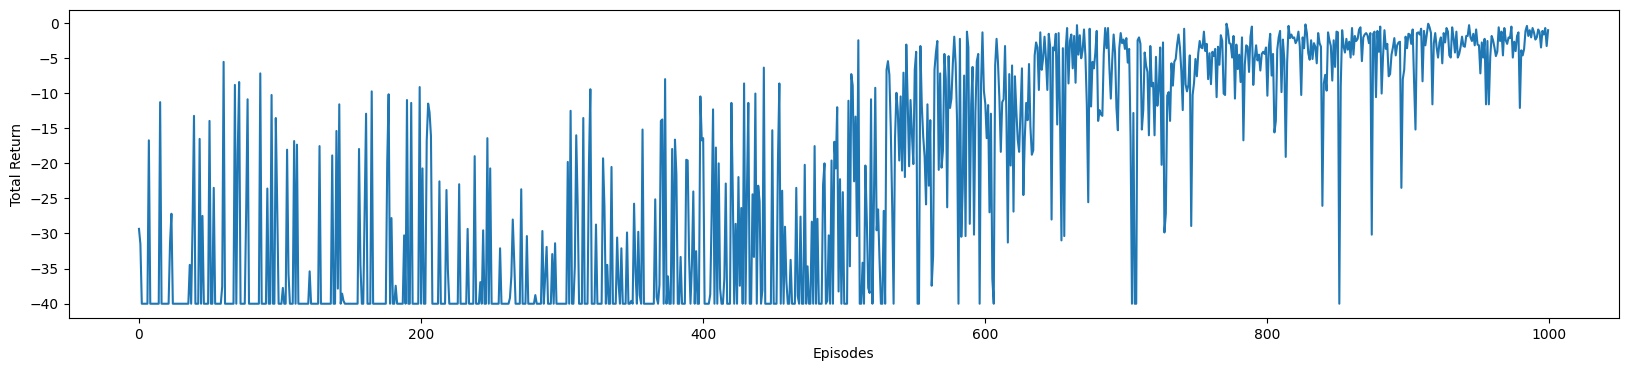

In [14]:
plt.figure(figsize=(20, 4))
plt.plot(all_rews)
plt.xlabel("Episodes")
plt.ylabel("Total Return")
plt.show()